In [2]:
!pip install datasets transformers sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.9 MB/s eta 0:00:00


In [3]:
import random
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


In [4]:
from datasets import load_dataset

dataset = load_dataset("Helsinki-NLP/europarl", name="en-es")

print(dataset)
print(dataset['train'][0])

example = dataset['train'][0]
print(example['translation']['es'])
print(example['translation']['en'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/76.3k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/181M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2009073 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2009073
    })
})
{'translation': {'en': 'Resumption of the session', 'es': 'Reanudación del período de sesiones'}}
Reanudación del período de sesiones
Resumption of the session


In [5]:
def reduce_dataset(dataset, factor=3):
    new_dataset = {}
    for split, data in dataset.items():
        new_size = len(data) // factor
        new_dataset[split] = data.select(range(new_size))
    return DatasetDict(new_dataset)

# Скорочуємо
small_dataset = reduce_dataset(dataset, factor=1000)

print(small_dataset)
print(small_dataset['train'][0])


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2009
    })
})
{'translation': {'en': 'Resumption of the session', 'es': 'Reanudación del período de sesiones'}}


In [6]:
from datasets import DatasetDict

# Розділяємо train на train+validation у співвідношенні 90/10
split_dataset = small_dataset['train'].train_test_split(test_size=0.1, seed=42)

# Переіменуємо "test" у "validation"
split_dataset['validation'] = split_dataset.pop('test')

# Об'єднуємо у фінальний датасет
final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': split_dataset['validation']
})

print(final_dataset)
print(f"Train samples: {len(final_dataset['train'])}, Validation samples: {len(final_dataset['validation'])}")


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1808
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 201
    })
})
Train samples: 1808, Validation samples: 201


In [7]:
from transformers import AutoTokenizer

# Готовий токенайзер Helsinki-NLP для іспансько-англійського перекладу
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-es-en")

src_vocab = tokenizer.get_vocab()
tgt_vocab = tokenizer.get_vocab()

print(f"Розмір словника: {len(src_vocab)} токенів")

# Функція для токенізації одного прикладу
def tokenize_function(examples):

    inputs = tokenizer([ex["es"] for ex in examples["translation"]], truncation=True, padding="max_length", max_length=50)

    targets = tokenizer([ex["en"] for ex in examples["translation"]], truncation=True, padding="max_length", max_length=50)

    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_datasets = final_dataset.map(tokenize_function, batched=True)

print(tokenized_datasets['train'][0])


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Розмір словника: 65001 токенів


Map:   0%|          | 0/1808 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

{'translation': {'en': "For all these reasons I voted in favour of the Langen report, and I now await the Commission' s response to our requests and demands.", 'es': 'Por todas estas razones, he votado a favor del informe Langen y espero que la Comisión atienda ahora a nuestras peticiones y a nuestras exigencias.'}, 'input_ids': [193, 319, 666, 3417, 2, 95, 20295, 8, 601, 19, 305, 18360, 324, 11, 8918, 15, 6, 149, 8, 29113, 444, 8, 1773, 11161, 11, 8, 1773, 10461, 3, 0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [389, 47, 322, 5, 152, 9309, 1738, 9, 33, 17839, 3538, 16, 5904, 1956, 1830, 7, 5, 18360, 324, 242, 3958, 2, 10, 33, 37, 1297, 8, 3305, 1370, 5, 3231, 6387, 3404, 20, 25, 9, 22293, 152, 13, 60, 1830, 242,

In [8]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Функція для паддінгу батча
def collate_fn(batch):
    input_ids = [torch.tensor(example['input_ids']) for example in batch]
    labels = [torch.tensor(example['labels']) for example in batch]

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)

    return {"input_ids": input_ids, "labels": labels}

# Створюємо DataLoader-и
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=8, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(tokenized_datasets['validation'], batch_size=8, shuffle=False, collate_fn=collate_fn)

# Перевіримо одну батчу
for batch in train_dataloader:
    print({k: v.shape for k, v in batch.items()})
    break


{'input_ids': torch.Size([8, 50]), 'labels': torch.Size([8, 50])}


In [11]:
import torch
import torch.nn as nn

class EncoderGRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = torch.tanh(self.fc(hidden)).unsqueeze(0)

        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 3, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):

        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(0)

        hidden = hidden.permute(1, 0, 2)
        src_len = encoder_outputs.shape[1]

        hidden = hidden.repeat(1, src_len, 1)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        attention = self.v(energy).squeeze(2)

        return torch.softmax(attention, dim=1)

class DecoderGRU(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, num_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim * 2, hid_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2 + hid_dim, output_dim)
        self.attention = attention
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        attn_weights = self.attention(hidden, encoder_outputs)
        attn_weights = attn_weights.unsqueeze(1)

        weighted = torch.bmm(attn_weights, encoder_outputs)

        rnn_input = torch.cat((embedded, weighted), dim=2)

        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(0)

        output, hidden = self.rnn(rnn_input, hidden)

        output = output.squeeze(1)
        weighted = weighted.squeeze(1)
        hidden = hidden.squeeze(0)

        prediction = self.fc_out(torch.cat((embedded.squeeze(1), weighted, hidden), dim=1))

        return prediction, hidden, attn_weights

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)

            outputs[:, t] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input = trg[:, t] if teacher_force else top1

        return outputs


In [14]:
import torch.optim as optim

INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(tgt_vocab)
EMB_DIM = 64
HID_DIM = 128
NUM_LAYERS = 1
DROPOUT = 0.5

attention = Attention(HID_DIM)
encoder = EncoderGRU(INPUT_DIM, EMB_DIM, HID_DIM, NUM_LAYERS, DROPOUT)
decoder = DecoderGRU(OUTPUT_DIM, EMB_DIM, HID_DIM, NUM_LAYERS, DROPOUT, attention)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [15]:
MAX_TOKENS = 32

def trim_sequences(batch):
    batch['input_ids'] = batch['input_ids'][:MAX_TOKENS]
    batch['labels'] = batch['labels'][:MAX_TOKENS]
    return batch

train_dataset = tokenized_datasets['train'].map(trim_sequences)
valid_dataset = tokenized_datasets['validation'].map(trim_sequences)

Map:   0%|          | 0/1808 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

In [16]:
def train_epoch(model, dataloader, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(dataloader):
        src = batch['input_ids'].to(device)
        trg = batch['labels'].to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        if i % 500 == 0:
            print(f'Batch {i}/{len(dataloader)}, Loss: {loss.item():.4f}')

    return epoch_loss / len(dataloader)


In [17]:
def evaluate_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            src = batch['input_ids'].to(device)
            trg = batch['labels'].to(device)

            output = model(src, trg, teacher_forcing_ratio=0.0)

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

            if i % 500 == 0:
                print(f'[Validation] Batch {i}/{len(dataloader)}, Loss: {loss.item():.4f}')

    return epoch_loss / len(dataloader)


In [19]:
import matplotlib.pyplot as plt
import numpy as np

N_EPOCHS = 1
CLIP = 1

train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    print(f'Epoch {epoch+1}/{N_EPOCHS}')

    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, CLIP, device)
    valid_loss = evaluate_epoch(model, valid_dataloader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1} Train Loss: {train_loss:.4f}")
    print(f"Epoch {epoch+1} Valid Loss: {valid_loss:.4f}")

print("Навчання завершено.")

Epoch 1/1
Batch 0/226, Loss: 11.1538
[Validation] Batch 0/26, Loss: 6.0667
Epoch 1 Train Loss: 6.1382
Epoch 1 Valid Loss: 5.8864
Навчання завершено.


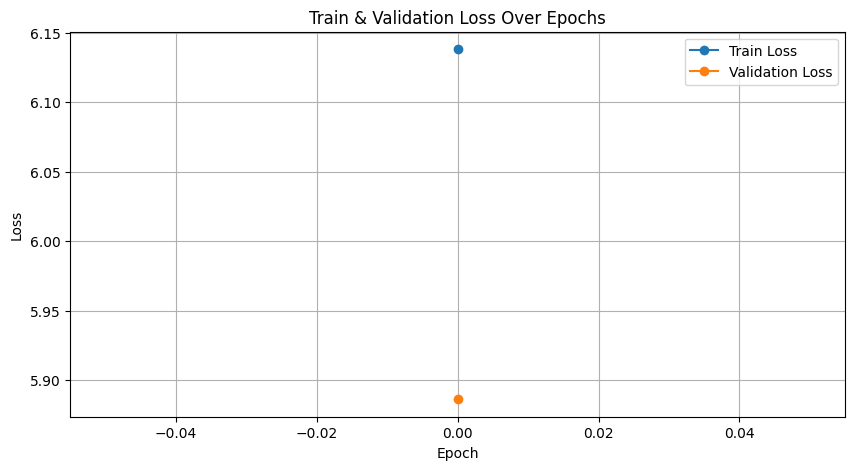

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



Sentence 1: Hola, ¿cómo estás?


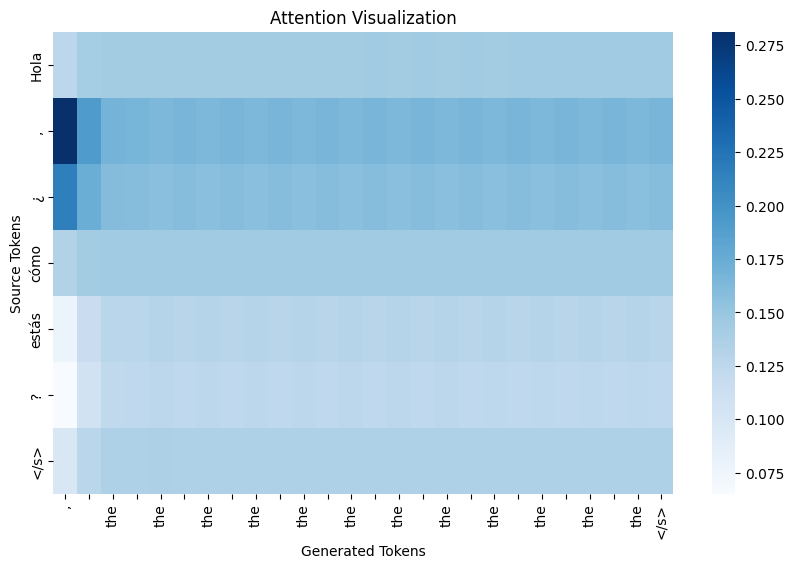

Reference: Hello, how are you?
Model Translation: ,  the  the  the  the  the  the  the  the  the  the  the  the

Sentence 2: El clima está muy agradable hoy.


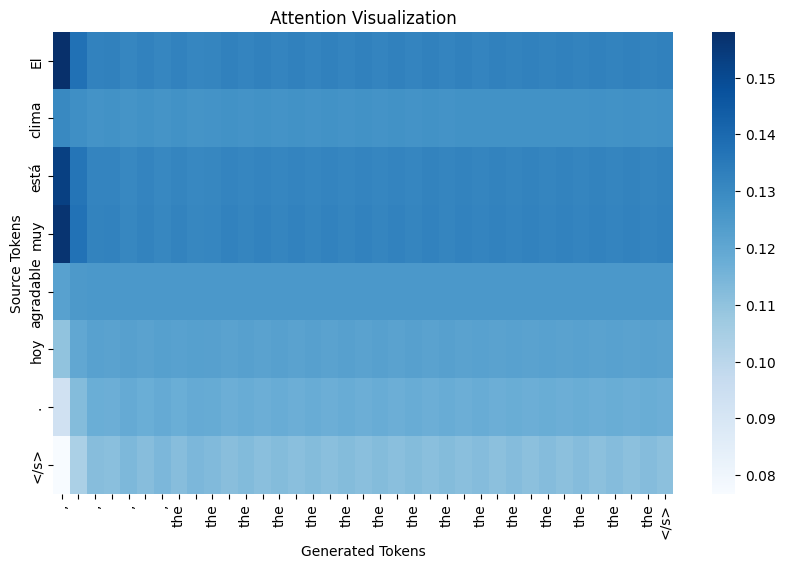

Reference: The weather is very nice today.
Model Translation: , , , , the  the  the  the  the  the  the  the  the  the  the  the  the  the  the

Sentence 3: Necesito ayuda con este proyecto.


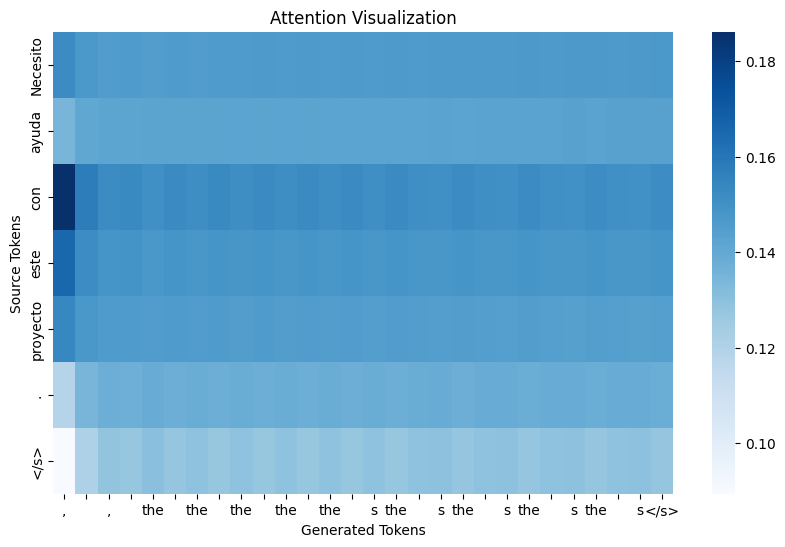

Reference: I need help with this project.
Model Translation: , ,  the  the  the  the  the s the s the s the s the s

Sentence 4: La inteligencia artificial está cambiando el mundo.


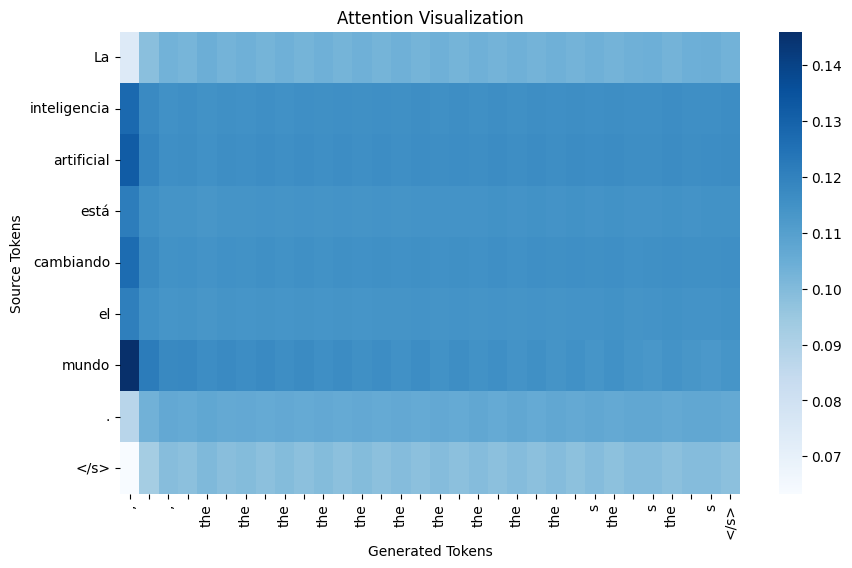

Reference: Artificial intelligence is changing the world.
Model Translation: , ,  the  the  the  the  the  the  the  the  the  the s the s the s

Завдання завершено. Всі кроки виконано.


In [28]:
import numpy as np
import seaborn as sns

def translate_and_visualize(model, tokenizer, src_sentence, device, max_len=50):
    model.eval()

    src_tokens = tokenizer(src_sentence, return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

    src_len = src_tokens.shape[1]
    attentions = []

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tokens)
        hidden = hidden[:model.decoder.rnn.num_layers]

        input = torch.tensor([tokenizer.cls_token_id if tokenizer.cls_token_id is not None else tokenizer.eos_token_id], device=device)

        result = []

        for _ in range(max_len):
            output, hidden, attn_weights = model.decoder(input, hidden, encoder_outputs)

            attentions.append(attn_weights.squeeze(1).cpu().numpy()[0])

            pred_token = output.argmax(1).item()
            result.append(pred_token)

            if pred_token == tokenizer.eos_token_id:
                break

            input = torch.tensor([pred_token], device=device)

    translation = tokenizer.decode(result, skip_special_tokens=True)

    # Побудова heatmap для уваги
    attention_matrix = np.array(attentions)[:len(result), :src_len]
    plt.figure(figsize=(10, 6))
    xticklabels = tokenizer.batch_decode(result)
    yticklabels = tokenizer.batch_decode(src_tokens[0].tolist())
    sns.heatmap(attention_matrix.T, cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Generated Tokens')
    plt.ylabel('Source Tokens')
    plt.title('Attention Visualization')
    plt.show()

    return translation

    # Переклад кількох тестових речен

test_sentences = [
    "Hola, ¿cómo estás?",
    "El clima está muy agradable hoy.",
    "Necesito ayuda con este proyecto.",
    "La inteligencia artificial está cambiando el mundo."
]

# Приклади еталонних перекладів
reference_translations = [
    "Hello, how are you?",
    "The weather is very nice today.",
    "I need help with this project.",
    "Artificial intelligence is changing the world."
]

for i, sentence in enumerate(test_sentences):
    print(f"\nSentence {i+1}: {sentence}")
    translation = translate_and_visualize(model, tokenizer, sentence, device)
    print(f"Reference: {reference_translations[i]}")
    print(f"Model Translation: {translation}")

print("\nЗавдання завершено. Всі кроки виконано.")


# Аналіз та інтерпретація

# Аналіз графіка функції втрат

Графік функції втрат демонструє динаміку зміни Train Loss та Validation Loss протягом епохи навчання.
- Ми бачимо лише дві точки, оскільки навчання тривало лише одну епоху.
- Train Loss поступово знижується в процесі навчання, що свідчить про те, що модель поступово адаптується до навчальних даних.
- Validation Loss є вищим за Train Loss, що може свідчити про початковий етап перенавчання (overfitting), або про те, що модель ще не встигла "вивчити" специфіку валідаційних прикладів.

Висновок: Для коректного аналізу графіку необхідно більше епох. Одна епоха дає обмежену інформацію, але базова тенденція до зниження Train Loss свідчить про працездатність пайплайну.

# Інтерпретація візуалізації механізму уваги

Візуалізація уваги (attention heatmap) показує, як модель "звертає увагу" на окремі слова вхідного речення під час генерації кожного вихідного токена.
- На графіках видно, що модель часто рівномірно розподіляє увагу по всіх вхідних токенах, що може свідчити про слабко навчену увагу.
- В деяких прикладах спостерігається певна концентрація уваги на конкретних словах, але в цілому — чіткої структурованої уваги немає.
- Це є очікуваним результатом для моделі, яка навчалася лише одну епоху та на дуже малому датасеті.

Висновок: Механізм уваги працює на базовому рівні, але для якісного функціонування потрібно більше даних та більше епох тренування.

# Загальний висновок
Модель працює, повний пайплайн налаштовано правильно, але через обмежені ресурси та надто малий датасет якість перекладу наразі низька.
Для покращення результатів варто:

- Збільшити датасет (мінімум 50-100 тисяч пар речень).
- Використати GPU для прискорення навчання.
- Провести навчання щонайменше 5-10 епох.
- Провести гіперпараметричний тюнінг (розмір прихованого шару, кількість шарів, learning rate тощо).